In [145]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage.color import rgb2lab, lab2rgb

import time

import torch
from torch import nn
import torchvision

In [146]:
# To ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [147]:
# use the Metal backend if available (for Apple computers)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
# use CUDA if available (for NVIDIA cards)
elif torch.cuda.is_available():
    device = torch.device('cuda')
# otherwise, use the CPU
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cpu


In [148]:
SIZE = 160

data_train_imagenette = torchvision.datasets.Imagenette("data", split='train', size="160px")
data_train_imagenette.transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((SIZE, SIZE), PIL.Image.BICUBIC),
    torchvision.transforms.ToTensor()
])
# data_train = torch.utils.data.Subset(data_train, torch.arange(1_000))
len(data_train_imagenette), data_train_imagenette[0][0].shape

(9469, torch.Size([3, 160, 160]))

In [149]:
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0]
        
        # Convert the image to the LAB color space
        img_lab = rgb2lab(img.permute(1, 2, 0).numpy())
        # Normalize the L channel to [-1, 1]
        img_lab[:, :, 0] = img_lab[:, :, 0] / 50 - 1
        # Normalize the AB channels to [-1, 1]
        img_lab[:, :, 1:] = img_lab[:, :, 1:] / 100

        # Returns the L channel (black and white) as the input 
        # and the AB channels (colors) as the target
        img_l, img_ab = torch.tensor(img_lab[:, :, 0]), torch.tensor(img_lab[:, :, 1:])
        return img_l, img_ab

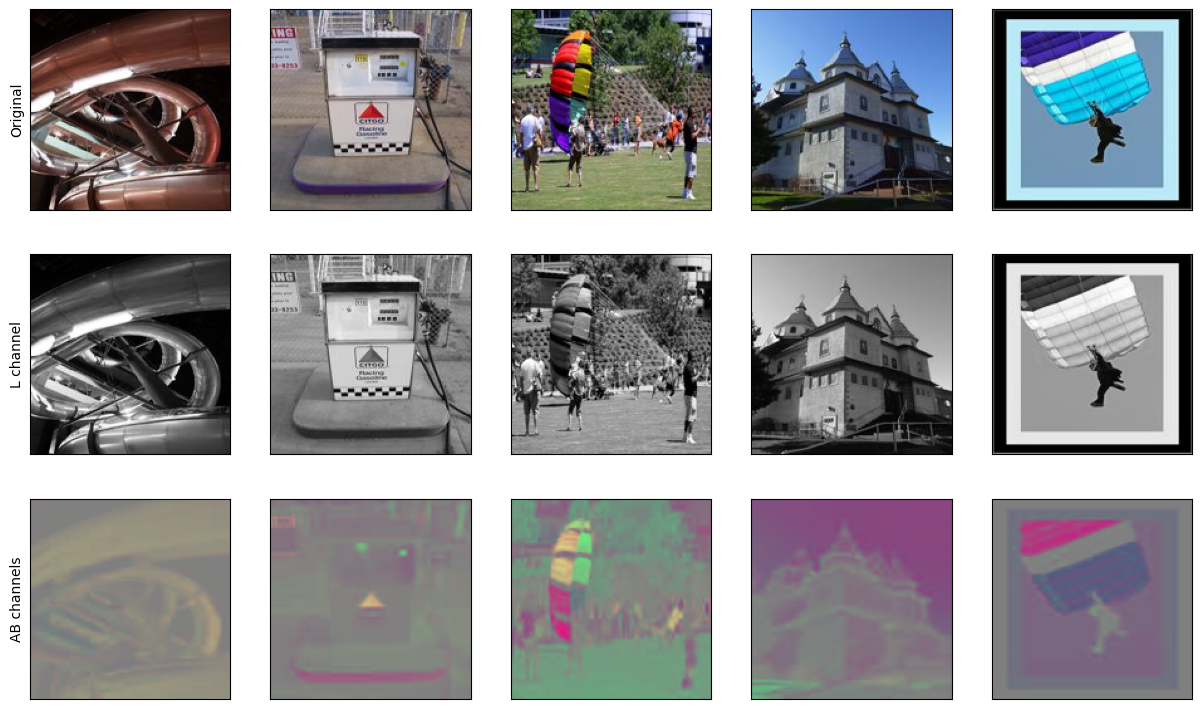

In [163]:
data_train = ColorizationDataset(data_train_imagenette)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    idx = np.random.randint(len(data_train_imagenette))
    original = data_train_imagenette[idx][0]
    source, target = data_train[idx]

    if i == 0:
        axs[0][i].set_ylabel('Original')
        axs[1][i].set_ylabel('L channel')
        axs[2][i].set_ylabel('AB channels')
    
    axs[0][i].imshow(original.permute(1, 2, 0))
    axs[1][i].imshow(source, cmap='gray')
    axs[2][i].imshow((torch.cat((target, torch.zeros((SIZE, SIZE, 1))), dim=-1)+ 1) / 2)

for ax in axs.flat:
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])